In [ ]:
# GOAL: compute the PPA accessibility metric using Conveyal TIF instead of Sugar SHP.
# Ideally, get pop-weighted avg accessibility for all grid cells that intersect project line.

# PSUEDO CODE:

# load accessibility TIF (e.g., jobs accessible from each cell)

# load weight layer TIF (e.g., pop in each cell)

# for access and weight layer, select cells that intersect project line (or intersect a tiny buffer around it)
#The cells will need to be exact alignment to enable multplication for weighted avgs.

# Reference scripts in PEP's access analysis tools
# https://github.com/SACOG/PEP1/tree/main/accessibility/conveyal_output_analyzer


In [173]:
import pandas as pd
import arcpy
from shapely import wkt
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask

def esri_to_df(esri_obj_path, include_geom, field_list=None, index_field=None, 
               crs_val=None, dissolve=False):
    """
    Converts ESRI file (File GDB table, SHP, or feature class) to either pandas dataframe
    or geopandas geodataframe (if it is spatial data)
    esri_obj_path = path to ESRI file
    include_geom = True/False on whether you want resulting table to have spatial data (only possible if
        input file is spatial)
    field_list = list of fields you want to load. No need to specify geometry field name as will be added automatically
        if you select include_geom. Optional. By default all fields load.
    index_field = if you want to choose a pre-existing field for the dataframe index. Optional.
    crs_val = crs, in geopandas CRS string format, that you want to apply to the resulting geodataframe. Optional.
    dissolve = True/False indicating if you want the resulting GDF to be dissolved to single feature.
    """

    fields = field_list # should not be necessary, but was having issues where class properties were getting changed with this formula
    if not field_list:
        fields = [f.name for f in arcpy.ListFields(esri_obj_path)]

    if include_geom:
        import geopandas as gpd
        # by convention, geopandas uses 'geometry' instead of 'SHAPE@' for geom field
        f_esrishp = 'SHAPE@'
        f_gpdshape = 'geometry'
        fields = fields + [f_esrishp]

    data_rows = []
    with arcpy.da.SearchCursor(esri_obj_path, fields) as cur:
        for row in cur:
            rowlist = [i for i in row]
            if include_geom:
                geom_wkt = wkt.loads(rowlist[fields.index(f_esrishp)].WKT)
                rowlist[fields.index(f_esrishp)] = geom_wkt
            out_row = rowlist
            data_rows.append(out_row)  

    if include_geom:
        fields_gpd = [f for f in fields]
        fields_gpd[fields_gpd.index(f_esrishp)] = f_gpdshape
        
        out_df = gpd.GeoDataFrame(data_rows, columns=fields_gpd, geometry=f_gpdshape)

        # only set if the input file has no CRS--this is not same thing as .to_crs(), which merely projects to a CRS
        if crs_val: out_df.crs = crs_val

        # dissolve to single zone so that, during spatial join, points don't erroneously tag to 2 overlapping zones.
        if dissolve and out_df.shape[0] > 1: 
            out_df = out_df.dissolve() 
    else:
        out_df = pd.DataFrame(data_rows, index=index_field, columns=field_list)

    return out_df

def get_pts_near_line(tif, line_fc, valname):
    crs_to_use = "EPSG:3857"

    tifdata = rasterio.open(tif)
    line_gdf = esri_to_df(esri_obj_path=line_fc, include_geom=True, field_list=None, index_field=None, 
                   crs_val=crs_to_use, dissolve=False)
    line_gdf['geometry'] = line_gdf['geometry'].buffer(100) # distance in meters if EPSG 3857 (web mercator)

    mask_geom = line_gdf.geometry[0]
    vals_masked, valmasked_transform = mask(tifdata, shapes=[mask_geom], all_touched=True, crop=True, pad=True, pad_width=0.5)
    vals_array = vals_masked[0]

    # make vector point gdf from the pixels that are near the line. Will need to further trim to go from
    # rectangle of points to just points that are right along the line.
    # helpful site = https://gis.stackexchange.com/questions/388047/get-coordinates-of-all-pixels-in-a-raster-with-rasterio
    vals_array = vals_masked[0]
    row_range = np.arange(vals_array.shape[0])
    col_range = np.arange(vals_array.shape[1])

    coord_arr = []
    for r in row_range:
        for c in col_range:
            x, y = rasterio.transform.xy(valmasked_transform, r, c)
            val = vals_array[r][c]
            coord_arr.append({'cellid': f"{r}_{c}", 'x': x, 'y': y, valname: val})

    df = pd.DataFrame(coord_arr)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs=crs_to_use)
    
    return gdf

pop-weighted avg emp access: 82018.4921875


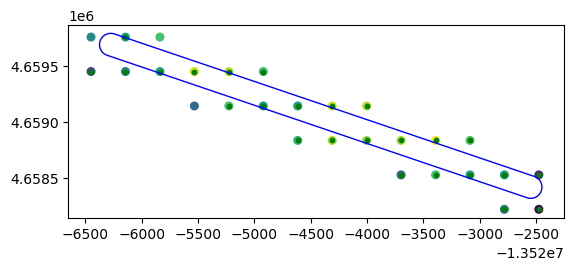

In [182]:
# Test selecting specific raster cells that are close to vector line
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask

tif_acc = r"I:\Projects\Darren\PPA3_GIS\AccessibilityAnalyses\tif\bike_jobs_2020.tif"
tif_wt = r"I:\Projects\Darren\PPA3_GIS\AccessibilityAnalyses\tif\pop2020.tif"
line_fc = r"\\data-svr\GIS\Projects\Darren\PPA3_GIS\PPA3Testing.gdb\TestBroadway16th"
destination = 'emp'
wt = 'pop'

gdf_acc = get_pts_near_line(tif_acc, line_fc, destination)
gdf_wt = get_pts_near_line(tif_wt, line_fc, wt)

acc_pts = gdf_acc.loc[gdf_acc[destination] > 0].plot(column=destination, markersize=30)
wt_pts = gdf_wt.loc[gdf_wt[wt] > 0].plot(ax=acc_pts, color='green', markersize=10)
line_gdf.plot(ax=acc_pts, color="none", edgecolor='blue')

dfjn = gdf_acc.merge(gdf_wt, on='cellid') # pd.concat([gdf_acc, gdf_wt])
wtd_avg = (dfjn[destination]*dfjn[wt]).sum() / dfjn['pop'].sum()
print(f"{wt}-weighted avg {destination} access: {wtd_avg}")

In [118]:
# export to shp via esri stuff
import arcpy
from arcgis.features import GeoAccessor, GeoSeriesAccessor

output_fc = r'I:\Projects\Darren\PPA3_GIS\AccessibilityAnalyses\accessibility_testing.gdb\test'
sedf = pd.DataFrame.spatial.from_geodataframe(gdf84)

# # make dtypes compatible with exporting to shp
# cdict = {'float64':'float'}

# for c in sedf.columns:
#     c_dt = sedf.dtypes[c].name
#     if c_dt in cdict.keys():
#         sedf[c] = sedf[c].astype(cdict[c_dt])
# sedf.info()

sedf.spatial.to_featureclass(output_fc, sanitize_columns=False)

'I:\\Projects\\Darren\\PPA3_GIS\\AccessibilityAnalyses\\accessibility_testing.gdb\\test'

In [120]:
line_gdf.geometry

0    POLYGON ((-13522540.848 4658441.593, -13522539...
Name: geometry, dtype: geometry